## Prepare the data

### 1. Load the fine-tuning data

In [3]:
import json

file_path = "../output/fine_tuning/data/fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

### 2. Load the tokenizer

In [4]:
import sys
sys.path.append('..')

In [5]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/dataset_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. Tokenize the sequences

In [6]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

19

### 4. Split the data

We need to be careful when splitting the data. We want to keep the multi-turn conversations complete in each part. So, the training and validation sets should start with a `You` message and end with an `Assistant` message.

In [7]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>User 2:'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>Eduardo Lomeli
End message: <|startoftext|>User 2:
[08/11/25, 20:56:47] Eduardo Lomeli

Validation set: 
Start message: <|startoftext|>User 2
End message: <|startoftext|>User 2


We got the index that we should use to split the data. Now, let's split the tokenized data.

In [8]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

Now, we need to combine the `You` and `Assistant` turns into one sequence. We will make sure that the resulting sequence does not exceed the `block_size`.

In [9]:
block_size = 1024


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [10]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 17950
Length after: 8975

Validation data
Length before: 9978
Length after: 4989


We will merge the `You` and `Assistant` parts into one sequence. Then, we will try to combine multiple sequences of `You` and `Assistant` into a single input, but only if the sequence length stays smaller than the block size.

In [11]:
def merge_conversation_turns(combined_data: list[list[int]], block_size: int) -> list[list[int]]:
    new_data = []
    current_sequence = []

    for sequence in combined_data:
        if len(current_sequence) + len(sequence) <= block_size:
            current_sequence.extend(sequence)
        else:
            if current_sequence:
                new_data.append(current_sequence)
            current_sequence = sequence.copy()

    # Add the last block if it's not empty
    if current_sequence:
        new_data.append(current_sequence)

    return new_data


merged_train_data = merge_conversation_turns(
    combined_data=combined_train_data,
    block_size=block_size
)
merged_val_data = merge_conversation_turns(
    combined_data=combined_val_data,
    block_size=block_size
)

In [12]:
len(combined_train_data), len(merged_train_data)

(8975, 389)

Let's convert each sequence of tokens into a tensor.

Since our token sequences don't all have the same length, we can't turn the data into a tensor all at once. To do that, all sequences need to have the same length.

That's why we need to use padding to fix this problem. We can add padding at the start or end of the sequence. Let's add it to the start.

In [13]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=merged_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=merged_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([389, 1024]), torch.Size([207, 1024]))

In [14]:
train_data_tensor[0]

tensor([16384,    69,   641,  ..., 16388, 16388, 16388])

In [15]:
val_data_tensor[0]

tensor([16384,    85,  1039,  ..., 16388, 16388, 16388])

### 5. Creat the data loaders

In [16]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [17]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([2, 1024]), torch.Size([2, 1024]))

## Fine-tuning

### 1. Load the saved checkpoint

In [18]:
import torch
torch.manual_seed(3647)

In [19]:
from transformer.model import GPTLanguageModel

block_size = 1024
n_embd = 512
n_head = 32
n_layer = 6
dropout = 0.2
batch_size = 2
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
#model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

36.23425 M parameters


In [20]:
checkpoint_path = "../output/pre_training/run_4/checkpoint_15000.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly.

In [21]:
input_tokens = tokenizer.encode("Hola como estas? ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Hola como estas?  es inevitabletentó y ausentarse de el pobre Willoughby, ¿Nada, ¿Es que observamos en sí mismos, Elinor! Prefieres buscar el infortunio para el mundo para el infortunio para Marianne y la culpa para el pobre Willoughby, Elinor! Mi otros planes que en sí mismos, antes que en general nos ha demostrado. Pero habría sido antes que en esa una disculpa para querer, porque se le debe al atolondramiento, y es posible hacer en sí mismos, simplemente


### 2. Estimate loss

In [22]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

### 3. Save checkpoints

In [23]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [24]:
max_iters = 20
eval_interval = 5
learning_rate = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/run_1/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 12.9760, val loss 12.8371
iteration 0 / step 5: train loss 9.0214, val loss 9.0044
iteration 0 / step 10: train loss 7.8538, val loss 7.8397
iteration 0 / step 15: train loss 7.0763, val loss 7.0951
iteration 0 / step 20: train loss 6.4518, val loss 6.4474
iteration 0 / step 25: train loss 5.9763, val loss 6.0069
iteration 0 / step 30: train loss 5.5643, val loss 5.6096
iteration 0 / step 35: train loss 5.2686, val loss 5.3173
iteration 0 / step 40: train loss 4.9768, val loss 5.0558
iteration 0 / step 45: train loss 4.7249, val loss 4.7946
iteration 0 / step 50: train loss 4.5027, val loss 4.5906
iteration 0 / step 55: train loss 4.3308, val loss 4.4194
iteration 0 / step 60: train loss 4.2151, val loss 4.3252
iteration 0 / step 65: train loss 4.1101, val loss 4.2255
iteration 0 / step 70: train loss 4.0514, val loss 4.1723
iteration 0 / step 75: train loss 3.9877, val loss 4.1103
iteration 0 / step 80: train loss 3.9417, val loss 4.0970
iteration 0 / 

KeyboardInterrupt: 

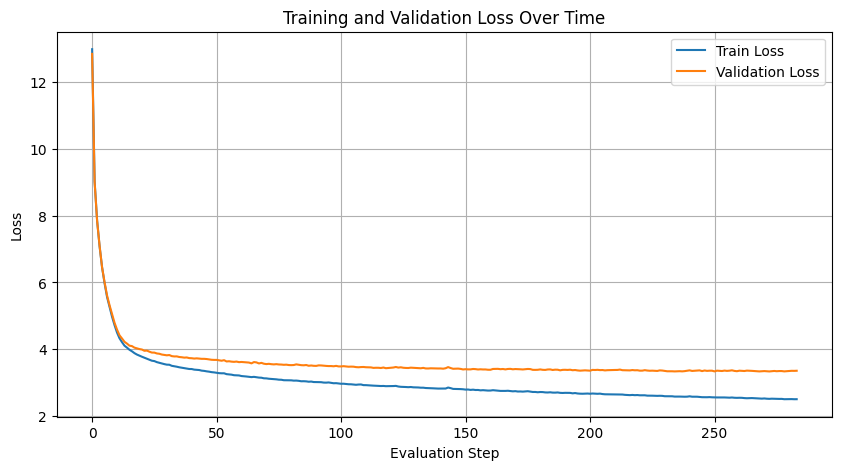

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [34]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "Hola"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        break

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: Hola
Assistant: Si no tardo Lomeli<|separator|>Thhhh: 8116?
